**Set of notes, present set underlined:<br>
6/11.14(1): Discretize momentum equations<br>
6/11.14(2): Derive pressure correction equation<br>
6/11.14(3): Rhie \& Chow interpolation<br>
6/11.14(4): SIMPLE algorithm with under-relaxation<br>
<u>6/11.14(5): SIMPLE example (Jupyter Notebook)</u>**

# SIMPLE collocated example

**A 1D example for non-equidistant collocated mesh (not in book).**

Inlet at west boundary (Dirichlet for velocity) and outlet at east boundary (homogeneous Neumann for velocity).

Momentum source term that counteracts the pressure gradient (to be calculated).

**Govering equations**

Steady-state continuity and momentum equations with a momentum source term, given by

$div(\rho {\bf u}) = 0$,

$div(\rho {\bf u} {\bf u}) = div(\mu \; grad \;{\bf u}) - grad(p) + {\bf b}$,

where ${\bf b} = ( b, 0, 0 )$ is a momentum source term in the x-direction.

* Do volume integral of all terms, assuming constant values in cells.
* Apply Gauss' theorem for $div$-terms, assuming constant values at faces.
* Remove non-1D terms.
* Divide by constant cross-sectional face area.

We get

$(\rho u)_e - (\rho u)_w = 0$,

$(\rho u u)_e - (\rho u u)_w =  \left( \mu \frac{d u}{d x}\right)_e - \left( \mu \frac{d u}{d x}\right)_w + (-\frac{d p}{d x} + b) dx_{we}$,

where $dx_{we}$ is the remainder of the cell volume after division by the face area.

We assume constant $\rho$ and $\mu$.

The solution is a constant velocity in the computational domain (same as inlet velocity, due to continuity) and a pressure gradient that counteracts the momentum source term (removes the last term in the momentum equation). Make sure that you can figure this out by physical knowledge, so you can later make a sanity-check of the results!!! You should always make such sanity-checks! To get this solution numerically, we must fulfill both equations above through the SIMPLE algorithm.

**Discretize the momentum equation**

* Apply central differencing for $\frac{d u}{d x}$.
* Use the upwind scheme for the velocity at the faces.
* Evaluate pressure gradient using central differencing, based on interpolated face values.
* Define $F_w = (\rho u)_w$, $F_e = (\rho u)_e$, $D_w = \mu/d x_{WP}$ and $D_e = \mu/d x_{PE}$
* Gather coefficients and source terms in the general form.
* Apply implicit under-relaxation

We get (note superscript $u$ for coefficients and source terms)

$a_P^u u_P = a_W^u u_W + a_E^u u_E + S_u^u, \; a_P^u = a_W^u + a_E^u - S_P^u$,

where

$a_W^u = D_w + max(F_w, 0)$

$a_E^u = D_e + max(0, -F_e)$

$S_u^u = (-\frac{p_e-p_w}{d x_{we}} + b) dx_{we}$

$S_P^u = F_w -F_e$

This $S_P^u$ may become positive during the iterative procedure, so in the code we instead put any positive value for $S_P^u$ as an addition to $S_u^u$, as $S_u^u = S_u^u + S_P^u*u$, where $S_P^u*u$ is explicitly calculated using the present value of $u$ (which requires outer iterations). Note that it is also possible to set $S_P^u = 0$ during the iterations!

As usual, once all coefficients above have been computed, the central coefficient is calculated as

$a^u_P = a^u_E + a^u_W - S^u_P$

Apply implicit underrelaxation as

$a^u_P = \frac{a^u_P}{\alpha_u}$

$S^u_u = S^u_u + \left[ (1-\alpha_u) \frac{a^u_P}{\alpha_u} \right] u^{(n-1)}$ (be careful if $a^u_P$ has already been divided by $\alpha_u$!

Note that upper-case and lower-case subscripts refer to nodes and faces, respectively.

We need some values at faces, where they are not stored.

* $D_w$ and $D_e$ can be calculated.
* $F_w$ and $F_e$ need to be determined by pressure-velocity coupling!!!

***Boundary conditions for momentum equation***

* Dirichlet at west boundary: Just use the non-equidistant discretization.
* Homogeneous Neumann at east boundary: Set $a^u_E = 0$ before calculating $a^u_P$.

**Reformulate the continity equation to a discretized pressure correction equation**

The derivation is the same as we have done before. Note that the additional source term, $b$, vanishes when the discretized momentum equation for the guessed fields ($u^*,\; p^*$),

$a_P^u u_P^* = \sum_{nb} a_{nb}^u u_{nb}^* + \left( \frac{(p_w^* - p_e^*)}{dx_{we}} + b \right)dx_{we}$,

is subtracted from the discretized momentum equation for the 'correct' fields ($u,\; p$),

$a_P^u u_P = \sum_{nb} a_{nb}^u u_{nb} + \left( \frac{(p_w - p_e)}{dx_{we}} + b \right)dx_{we}$,

to get the relation between $u'$ and $p'$ (after dropping the summation term) as

$a_P^u u_P' = (p_w' - p_e')$, or

$u_P' = d^u (p_w' - p_e'),\; d^u = \frac{1}{a_P^u}$

"Staggering" to the faces gives (with interpolated $a_P^u$)

$u_e' = d^u_e (p_P' - p_E'),\; d^u_e = \frac{1}{a_{P,e}^u}$

$u_w' = d^u_w (p_W' - p_P'),\; d^u_w = \frac{1}{a_{P,w}^u}$

This is the same as in our previous derivation, so the discretized pressure correction equation is exactly as before (no superscripts on coefficients and source terms), yielding

$a_P p_P' = a_W p_W' + a_E p_E' + S_u, \; a_P = a_W + a_E - S_P$,

where

$a_W = \rho d^u_w$,

$a_E = \rho d^u_e$,

$S_u = F_w - F_e$ (using Rhie & Chow interpolation for non-equidistant mesh! See code.),

$S_P = 0$,

$d^u = 1/a_P^u$ (to be interpolated to east and west faces).

Again, note that upper-case and lower-case subscripts refer to nodes and faces, respectively.

We need some values at faces, where they are not stored.

* $F_w$ and $F_e$ need to be determined, using Rhie & Chow interpolation!!!
* $a_P^u$ is needed at the faces!!! Note that it is already under-relaxed!

***Boundary condition for pressure correction equation***

* Homogeneous Neumann at both boundaries: Set $a_W = 0$ and $a_E = 0$, respectively, before calculating $a_P$.

***Setting pressure level***

We set pressure to zero in one node by an initial guess of zero and forcing the pressure correction to zero as

$S_u = 10^{30} * 0.0$

$S_P = -10^{30}$

Note that it should be done before $a_P$ is calculated (using $S_P$)!

It is good to also subtract any truncation error in that node from the entire field after solution.

***Explicit underrelaxation of pressure***

Correct pressure as

$p = p^* + \alpha_p p^\prime$

**SIMPLE algorithm**

Guess pressure and velocity fields.

Repeat the following until convergence:

* Solve momentum equation
* Solve pressure correction equation
* Correct: 1) Pressure in nodes. 2) Face fluxes. 3) Velocity in nodes

**Implementation and solution of the discretized equations**

Click on a cell to select it, and **press Shift-Enter to run the code in the marked cell and move to the next cell** (after first understanding the code). The output of each piece of code will be used in subsequent pieces of codes at the time when you run that code, so it is important to run the pieces of code in the right order (top to bottom). Follow the instructions at the end on how to iterate manually.

If you want to restart from scratch, click on Kernel/Restart & Clear Output.

Let's start by intializing a Python code and set some values needed for the particular case:

In [1]:
import numpy as np
import copy as cp
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
plt.rcParams.update({'font.size': 12})

#Fluid properties:
mu = 1.0
rho = 1.0

#West Dirichlet condition for velocity:
uWest = 0.1

#u-momentum source term (to be counteracted by final pressure gradient): 
b = -0.05

#SIMPLE iteration counter (for plotting):
simpleIter = 0

####################################################
# The rest is just for showing numbers

print("mu:    % .5e" % (mu))
print("rho:   % .5e" % (rho))
print("uWest: % .5e" % (uWest))
print("b:     % .5e" % (b))

mu:     1.00000e+00
rho:    1.00000e+00
uWest:  1.00000e-01
b:     -5.00000e-02


All coefficients and source terms need information from the mesh!

Create and show a mesh with two cells:

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.


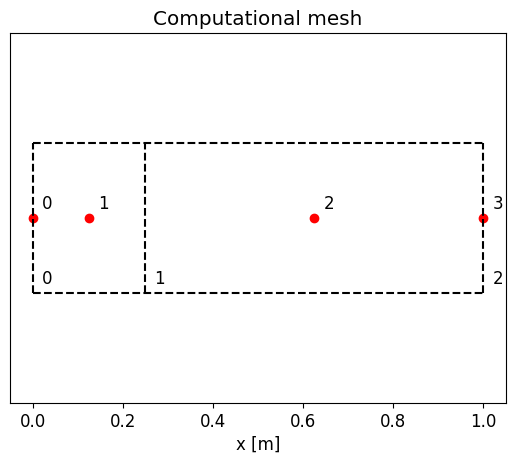

In [2]:
#Specify mesh point positions:
#Only change the center position, not to mess up plots!
pX = np.array([0.0, 0.25, 1.0])

#Calculate mesh node positions from point positions:
nX = np.array([pX[0],          \
              (pX[0]+pX[1])/2, \
              (pX[1]+pX[2])/2, \
               pX[2]])

####################################################
# The rest is just for plotting

# Plot "mesh" and nodes (mesh height set to get nice figure)
nPoints = np.size(pX)
nNodes = nPoints + 1
plt.figure('Computational mesh')
plt.plot(nX, np.zeros(nNodes), 'ro')
height = (np.max(pX) - np.min(pX))/nPoints
plt.plot(pX, np.ones(nPoints)*height/2, '--k')
plt.plot(pX, -np.ones(nPoints)*height/2, '--k')
for i in range(0,nPoints):
    plt.plot(np.array([pX[i],pX[i]]), np.array([-1,1])*height/2, '--k')
#Node and point numbers:
plt.text(nX[0]+0.02,0.02,"0")
plt.text(nX[1]+0.02,0.02,"1")
plt.text(nX[2]+0.02,0.02,"2")
plt.text(nX[3]+0.02,0.02,"3")
plt.text(pX[0]+0.02,-height/2 + 0.02,"0")
plt.text(pX[1]+0.02,-height/2 + 0.02,"1")
plt.text(pX[2]+0.02,-height/2 + 0.02,"2")
# Plot settings
plt.xlabel('x [m]')
plt.title('Computational mesh')
plt.axis('equal')
#plt.xlim([np.min(pX) - height, np.max(pX) + height])
plt.ylim([-(height/2+0.50+0.05), height/2+0.50+0.05])
# Don't show y-axis ticks and labels:
fig = plt.gca()
y_axis = fig.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()

Later you can test to move the center point to see if the code works for another mesh distribution. But first go though everything with the present mesh.

Calculate the distances needed to calculate the coefficients and source terms:

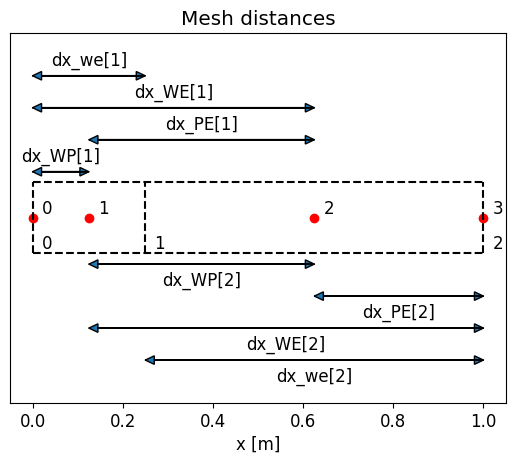

dx_WP[1]:  1.25000e-01, dx_WP[2]:  5.00000e-01
dx_PE[1]:  5.00000e-01, dx_PE[2]:  3.75000e-01
dx_WE[1]:  6.25000e-01, dx_WE[2]:  8.75000e-01
dx_we[1]:  2.50000e-01, dx_we[2]:  7.50000e-01


In [3]:
#Set "nan" where values are not needed, to number arrays consistently:
nan = float("nan")

#Mesh details, for discretization:
dx_WP = np.array([nan,         \
                  nX[1]-nX[0], \
                  nX[2]-nX[1], \
                  nan])
dx_PE = np.array([nan,         \
                  nX[2]-nX[1], \
                  nX[3]-nX[2], \
                  nan])
dx_WE = np.array([nan,         \
                  nX[2]-nX[0], \
                  nX[3]-nX[1], \
                  nan])
dx_we = np.array([nan,         \
                  pX[1]-pX[0], \
                  pX[2]-pX[1], \
                  nan])

####################################################
# The rest is just for plotting and showing numbers

# Plot "mesh" and nodes (mesh height set to get nice figure)
nPoints = np.size(pX)
nNodes = nPoints + 1
plt.figure('Mesh distances')
plt.plot(nX, np.zeros(nNodes), 'ro')
height = (np.max(pX) - np.min(pX))/nPoints
plt.plot(pX, np.ones(nPoints)*height/2, '--k')
plt.plot(pX, -np.ones(nPoints)*height/2, '--k')
for i in range(0,nPoints):
    plt.plot(np.array([pX[i],pX[i]]), np.array([-1,1])*height/2, '--k')
#Node and point numbers:
plt.text(nX[0]+0.02,0.02,"0")
plt.text(nX[1]+0.02,0.02,"1")
plt.text(nX[2]+0.02,0.02,"2")
plt.text(nX[3]+0.02,0.02,"3")
plt.text(pX[0]+0.02,-height/2 + 0.02,"0")
plt.text(pX[1]+0.02,-height/2 + 0.02,"1")
plt.text(pX[2]+0.02,-height/2 + 0.02,"2")
#dx_WP[1]:
plt.arrow(nX[0],height/2+0.05,dx_WP[1]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(nX[1],height/2+0.05,-(dx_WP[1]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((nX[0]+nX[1])/2,height/2+0.05+0.05, 'dx_WP[1]', horizontalalignment = 'center')
#dx_PE[1]:
plt.arrow(nX[1],height/2+0.2,dx_PE[1]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(nX[2],height/2+0.2,-(dx_PE[1]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((nX[1]+nX[2])/2,height/2+0.2+0.05, 'dx_PE[1]', horizontalalignment = 'center')
#dx_WE[1]:
plt.arrow(nX[0],height/2+0.35,dx_WE[1]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(nX[2],height/2+0.35,-(dx_WE[1]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((nX[0]+nX[2])/2,height/2+0.35+0.05, 'dx_WE[1]', horizontalalignment = 'center')
#dx_we[1]:
plt.arrow(pX[0],height/2+0.50,dx_we[1]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(pX[1],height/2+0.50,-(dx_we[1]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((pX[0]+pX[1])/2,height/2+0.50+0.05, 'dx_we[1]', horizontalalignment = 'center')
#dx_WP[2]:
plt.arrow(nX[1],-(height/2+0.05),dx_WP[2]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(nX[2],-(height/2+0.05),-(dx_WP[2]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((nX[1]+nX[2])/2,-(height/2+0.05+0.1), 'dx_WP[2]', horizontalalignment = 'center')
#dx_PE[2]:
plt.arrow(nX[2],-(height/2+0.2),dx_PE[2]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(nX[3],-(height/2+0.2),-(dx_PE[2]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((nX[2]+nX[3])/2,-(height/2+0.2+0.1), 'dx_PE[2]', horizontalalignment = 'center')
#dx_WE[2]:
plt.arrow(nX[1],-(height/2+0.35),dx_WE[2]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(nX[3],-(height/2+0.35),-(dx_WE[2]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((nX[1]+nX[3])/2,-(height/2+0.35+0.1), 'dx_WE[2]', horizontalalignment = 'center')
#dx_we[2]:
plt.arrow(pX[1],-(height/2+0.50),dx_we[2]-0.02,0, head_length = 0.02, head_width = 0.04)
plt.arrow(pX[2],-(height/2+0.50),-(dx_we[2]-0.02),0, head_length = 0.02, head_width = 0.04)
plt.text((pX[1]+pX[2])/2,-(height/2+0.50+0.1), 'dx_we[2]', horizontalalignment = 'center')

# Plot settings
plt.xlabel('x [m]')
plt.title('Mesh distances')
#plt.axis('equal')
#plt.xlim([np.min(pX) - height, np.max(pX) + height])
plt.ylim([-(height/2+0.65+0.05), height/2+0.65+0.05])
# Don't show y-axis ticks and labels:
fig = plt.gca()
y_axis = fig.axes.get_yaxis()
y_axis.set_visible(False)
plt.show()

print("dx_WP[1]: % .5e, dx_WP[2]: % .5e" % (dx_WP[1], dx_WP[2]))
print("dx_PE[1]: % .5e, dx_PE[2]: % .5e" % (dx_PE[1], dx_PE[2]))
print("dx_WE[1]: % .5e, dx_WE[2]: % .5e" % (dx_WE[1], dx_WE[2]))
print("dx_we[1]: % .5e, dx_we[2]: % .5e" % (dx_we[1], dx_we[2]))

Calculate constant coefficients for the momentum equation.

In [4]:
#Constant contributions to mom.eq. discretization (reused later):
Dw = np.array([nan,         \
               mu/dx_WP[1], \
               mu/dx_WP[2], \
               nan])
De = np.array([nan,         \
               mu/dx_PE[1], \
               mu/dx_PE[2], \
               nan])

####################################################
# The rest is just for showing numbers

print("Dw[1]: % .5e, Dw[2]: % .5e" % (Dw[1], Dw[2]))
print("De[1]: % .5e, De[2]: % .5e" % (De[1], De[2]))

Dw[1]:  8.00000e+00, Dw[2]:  2.00000e+00
De[1]:  2.00000e+00, De[2]:  2.66667e+00


Initialize fields and set Dirichlet condition for velocity at west boundary:

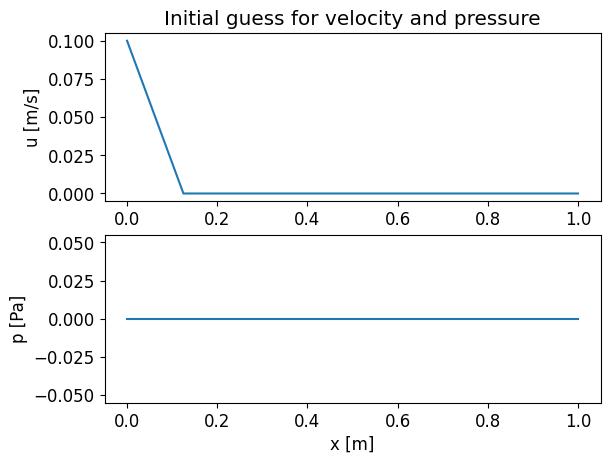

In [5]:
#Initial fields and velocity Dirichlet condition at west boundary:
u = np.array([uWest, 0.0, 0.0, 0.0])
p = np.array([0.0, 0.0, 0.0, 0.0])

####################################################
# The rest is just for plotting

uDiffMax = u[0]
for i in range(1, len(u)):
    if np.abs(u[i]-u[0]) > uDiffMax: uDiffMax = np.abs(u[i]-u[0])

simpleFig, (simpleAx1, simpleAx2) = plt.subplots(2,1)
simpleAx1.set_ylabel('u [m/s]')
simpleAx1.set_title('Initial guess for velocity and pressure')
simpleAx1.plot(nX, u, label=0)
simpleAx2.set_xlabel('x [m]')
simpleAx2.set_ylabel('p [Pa]')
simpleAx2.plot(nX, p, label=0)

For interpolation on a non-equidistant mesh we need interpolation weights.

Here they are defined as the portion to use from the value at the neighboring node.

In [6]:
#Linear interpolation factors to get face values (for each internal node):
f_w = (dx_we/2)/dx_WP #Multiply P with (1-f_w) and neighbour with f_w
f_e = (dx_we/2)/dx_PE #Multiply P with (1-f_e) and neighbour with f_e

####################################################
# The rest is just for showing numbers

print("f_w[1]: % .5e, f_w[2]: % .5e" % (f_w[1], f_w[2]))
print("f_e[1]: % .5e, f_e[2]: % .5e" % (f_e[1], f_e[2]))

f_w[1]:  1.00000e+00, f_w[2]:  7.50000e-01
f_e[1]:  2.50000e-01, f_e[2]:  1.00000e+00


Use interpolation factors to make a first estimation of the convective face fluxes:

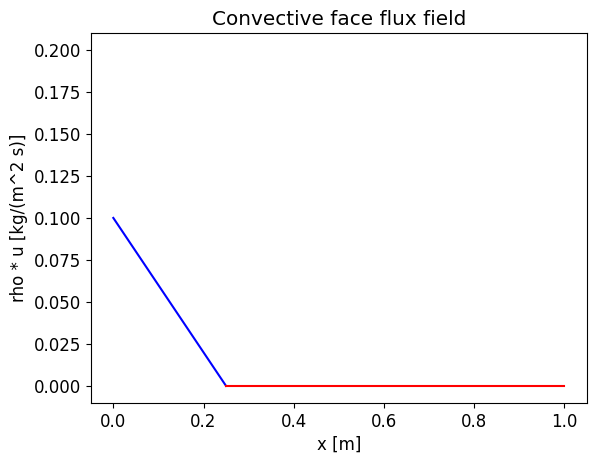

Blue line: Fw[1]:  1.00000e-01, Fw[2]:  0.00000e+00
Red line:  Fe[1]:  0.00000e+00, Fe[2]:  0.00000e+00


In [7]:
#Initial guess for face fluxes, based on initial velocity:
Fw = np.array([nan,                                 \
               rho*(f_w[1]*u[0] + (1-f_w[1])*u[1]), \
               rho*(f_w[2]*u[1] + (1-f_w[2])*u[2]), \
               nan])
Fe = np.array([nan,                                 \
               rho*((1-f_e[1])*u[1] + f_e[1]*u[2]), \
               rho*((1-f_e[2])*u[2] + f_e[2]*u[3]), \
               nan])
#Known Dirichlet boundary condition (best to set, to avoid truncation errors):
Fw[1] = rho * u[0]

####################################################
# The rest is just for plotting and showing numbers

# Plot velocity field
plt.figure('Convective face flux field')
plt.plot([pX[0],pX[1]], [Fw[1],Fw[2]], 'b')
plt.plot([pX[1],pX[2]], [Fe[1],Fe[2]], 'r')
# Plot settings
plt.xlabel('x [m]')
plt.ylabel('rho * u [kg/(m^2 s)]')
plt.title('Convective face flux field')
plt.ylim([rho*(u[0]-uDiffMax*1.1), rho*(u[0]+uDiffMax*1.1)])
plt.show()

print("Blue line: Fw[1]: % .5e, Fw[2]: % .5e" % (Fw[1], Fw[2]))
print("Red line:  Fe[1]: % .5e, Fe[2]: % .5e" % (Fe[1], Fe[2]))

In the code below:

1. Calculate the coefficients and source terms for the momentum equation, including under-relaxation.
2. Note that they depend on the convective face fluxes, which need to be updated later.
3. Make sure that $S_P < 0$.

Some booleans are set to prevent from errors due to irrational clicking...

Start of SIMPLE loop below (invisible cell id in markdown in this cell, to easily go back later)
<a id='STEP_1'></a>

In [8]:
##########
# STEP 1 #
##########

#SIMPLE iteration counter, for plotting:
simpleIter += 1

#Under-relaxation factor needed here:
alphau = 0.7

#u-momentum equation coefficients and source terms:
#Upwind for convection and central differencing for diffusion.
aWu = Dw + np.maximum(Fw, 0)
aEu = De + np.maximum(0, -Fe)
#Homogeneous Neumann at east boundary:
aEu[2] = 0
Suu = np.array([nan,                                  \
                f_w[1]*p[0]+(f_e[1]-f_w[1])*p[1]-f_e[1]*p[2] + b*dx_we[1], \
                f_w[2]*p[1]+(f_e[2]-f_w[2])*p[2]-f_e[2]*p[3] + b*dx_we[2], \
                nan])
#Following continuity error in Spu may be assumed to be zero
Spu = np.array([nan,         \
                Fw[1]-Fe[1], \
                Fw[2]-Fe[2], \
                nan])
#Spu = np.array([nan, 0, 0, nan]) #Test to set it to zero
#May occasionally cause Spu>0 and reduced diagonal dominance. Fix:
Suu = Suu + np.maximum(Spu,0)*u
Spu = -np.maximum(-Spu,0)
aPu = aWu + aEu - Spu

#Underrelax (note that aPu will subsequently already have been modified):
aPu = aPu/alphau
Suu = Suu + (1-alphau)*aPu*u #aPu already modified at previous line!

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
pCorrected = False
uCorrected = False
Fcorrected = False

Do Gauss-Seidel sweeps in both directions, since the propagation of the solution depends on the direction of the sweep (why?).

Click Run several times to see the convergence of the result for an additional set of Gauss-Seidel iterations.

A semi-implicit correction is made at the east boundary. Is that necessary? Why is it done?

Note: In a real implementation a residual and a convergence criterion should be used for the Gauss-Seidel loop!

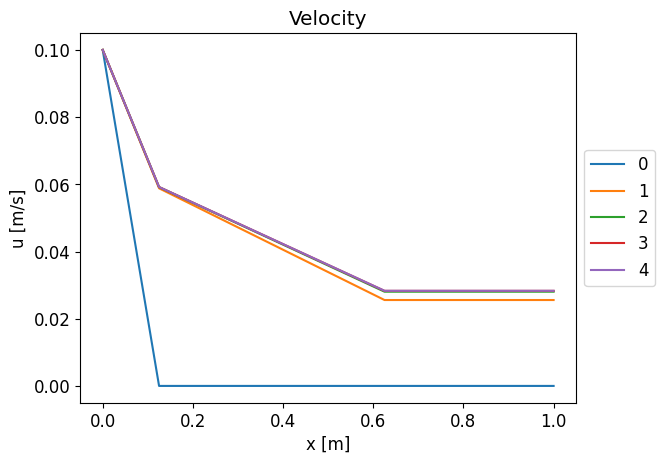

In [9]:
##########
# STEP 2 #
##########

#Prepare plot:
fig1, ax1 = plt.subplots()
ax1.set_xlabel('x [m]')
ax1.set_ylabel('u [m/s]')
ax1.set_title('Velocity')
ax1.plot(nX, u, label=0) #Include initial values

#Specify number of Gauss-Seidel iterations to do each time this piece of code is executed:
uGaussSeidelIter = 4

#Gauss-Seidel iteration,
#with built-in semi-implicit hom. Neumann (for "visualization"):
for gsIter in range(1,uGaussSeidelIter+1):
    #Unrolled loops over nodes for pedagogical reasons.
    #One sweep in each direction, although not necessary in this case.
    i=1; u[i] = (aWu[i]*u[i-1] + aEu[i]*u[i+1] + Suu[i])/aPu[i]
    i=2; u[i] = (aWu[i]*u[i-1] + aEu[i]*u[i+1] + Suu[i])/aPu[i]
    i=2; u[i] = (aWu[i]*u[i-1] + aEu[i]*u[i+1] + Suu[i])/aPu[i]
    i=1; u[i] = (aWu[i]*u[i-1] + aEu[i]*u[i+1] + Suu[i])/aPu[i]
    #Semi-implicit correction at hom. Neumann boundary:
    u[3] = u[2]
    #Plot result at end of each loop:
    ax1.plot(nX, u, label=gsIter)

ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))

We get a solution that fulfils the present equation, but it is not the correct solution. Why?

Answer:
1.   The convection part of the coefficients depend on old values of the face fluxes that are fixed.
2.   The source term depends on the pressure gradient that must be calculated by the SIMPLE algorithm.

We need to set up and solve the pressure correction equation.

For the source term we need the continuity error of the present velocity field, which should be determined using the face fluxes that are calculated using Rhie & Chow interpolation (make sure that you can derive the below used Rhie & Chow correction for non-equidistant meshes):

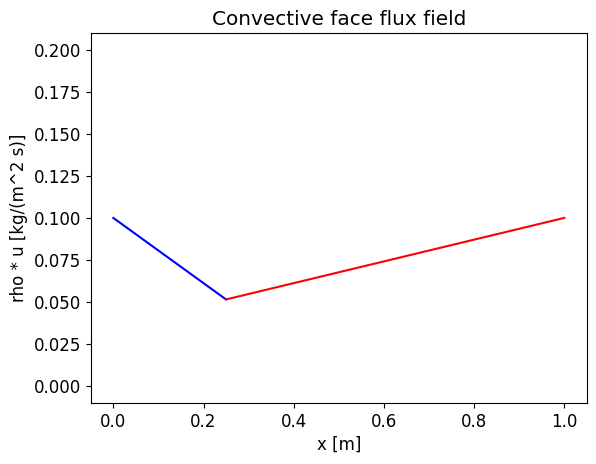

Blue line: Fw[1]:  1.00000e-01, Fw[2]:  5.14749e-02
Red line:  Fe[1]:  5.14749e-02, Fe[2]:  1.00000e-01


In [10]:
##########
# STEP 3 #
##########

#Update face fluxes...
#First linear interpolation at internal faces only:
Fe[1] = rho*((1-f_e[1])*u[1] + f_e[1]*u[2])
#Then Rhie & Chow at internal faces only:
#Compare subtracted pressure gradients with Suu (excluding source term)!
#Entire coefficient of added pressure gradient must be interpolated!
Fe[1] = Fe[1] +                                                      \
        rho*(-(1-f_e[1])*(-(p[2]-p[0])/dx_WE[1])*dx_we[1]/aPu[1]     \
             -   f_e[1] *(-(p[3]-p[1])/dx_WE[2])*dx_we[2]/aPu[2]     \
             + ((1-f_e[1])*dx_we[1]/aPu[1] + f_e[1]*dx_we[2]/aPu[2]) \
             *(p[1]-p[2])/dx_PE[1])
#Similar for west face fluxes. Here we use the Fe value at the
#internal face that has already been Rhie & Chow corrected:
Fw[2] = Fe[1]
#Make sure that known boundary condition is set (should actually be untouched):
Fw[1] = rho*u[0]
#Force global continuity, needed by pp equation:
Fe[2] = Fw[1]

####################################################
# The rest is just for plotting and showing numbers

# Plot velocity field
plt.figure('Convective face flux field')
plt.plot([pX[0],pX[1]], [Fw[1],Fw[2]], 'b')
plt.plot([pX[1],pX[2]], [Fe[1],Fe[2]], 'r')
# Plot settings
plt.xlabel('x [m]')
plt.ylabel('rho * u [kg/(m^2 s)]')
plt.title('Convective face flux field')
plt.ylim([rho*(u[0]-uDiffMax*1.1), rho*(u[0]+uDiffMax*1.1)])
plt.show()

print("Blue line: Fw[1]: % .5e, Fw[2]: % .5e" % (Fw[1], Fw[2]))
print("Red line:  Fe[1]: % .5e, Fe[2]: % .5e" % (Fe[1], Fe[2]))

In the code below:

1.   Calculate the coefficients for the pressure correction equation by linear interpolation of the central coefficient of the momentum equation.
2.   Calculate source term from present continuity error.
3.   Fix the pressure in one node by setting $p' = 0$ implicitly, such that the pressure will not be corrected in that node.
4.   Set $p'=0$ as a start guess each time the solution of the $p'$ equation is started, since that should be the final solution when all the equations are converged.



In [11]:
##########
# STEP 4 #
##########

#Pressure correction coefficients and source terms:
#Hom. Neumann west b.c. at index 1
dw = np.array([nan,                                   \
               0,                                     \
               1/(f_w[2]*aPu[1] + (1-f_w[2])*aPu[2]), \
               nan])
#Hom. Neumann east b.c. at index 2
de = np.array([nan,                                   \
               1/((1-f_e[1])*aPu[1] + f_e[1]*aPu[2]), \
               0,                                     \
               nan])
aW = np.array([nan, rho*dw[1], rho*dw[2], nan])
aE = np.array([nan, rho*de[1], rho*de[2], nan])
#Homogeneous Neumann at both boundaries:
aW[1] = 0
aE[2] = 0
Su = np.array([nan, Fw[1]-Fe[1], Fw[2]-Fe[2], nan])
Sp = np.array([nan, 0, 0, nan])
#Fix pressure by forcing pp to zero, through source terms:
Su[1] = pow(10,30) * 0.0
Sp[1] = -pow(10,30)
aP = aW + aE - Sp

#Initialize pressure correction to zero each SIMPLE iteration:
pp = np.array([0.0, 0.0, 0.0, 0.0])

In the code below:

1. Do some Gauss-Seidel iterations to converge the pressure correction equation (run several times to watch the convergence for next set of iterations).
2. Make sure that $p'=0$ in the chosen node, since the implict method will leave a remaining value of about $10^{-30}$.
3. Extrapolate $p'$ at the boundaries using homogeneous Neumann, since those values are neither affected nor used in the Gauss-Seidel iterations. Make sure that you can verify this!

Note: In a real implementation a residual and a convergence criterion should be used for the Gauss-Seidel loop!

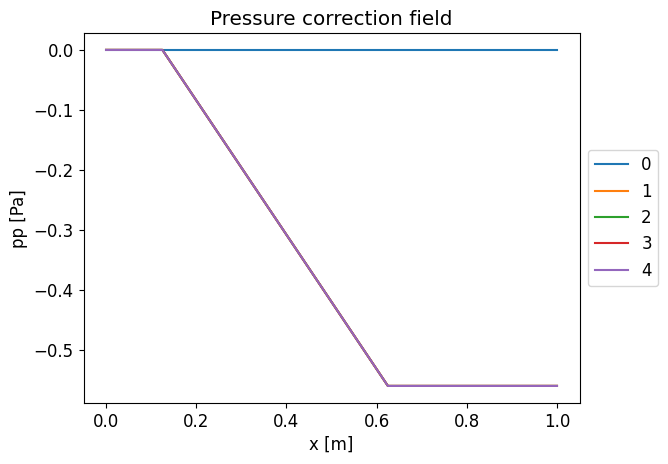

In [12]:
##########
# STEP 5 #
##########

#Prepare plot:
fig2, ax2 = plt.subplots()
ax2.set_xlabel('x [m]')
ax2.set_ylabel('pp [Pa]')
ax2.set_title('Pressure correction field')
ax2.plot(nX, pp, label=0) #Include initial values

#Specify number of Gauss-Seidel iterations to do each time this piece of code is executed:
ppGaussSeidelIter = 4

#Gauss-Seidel for pressure correction:
for gsIter in range(1,ppGaussSeidelIter+1):
    #Unrolled loops over nodes for pedagogical reasons.
    #One sweep in each direction, although not necessary in this case
    i=1; pp[i] = (aW[i]*pp[i-1] + aE[i]*pp[i+1] + Su[i])/aP[i]
    i=2; pp[i] = (aW[i]*pp[i-1] + aE[i]*pp[i+1] + Su[i])/aP[i]
    i=2; pp[i] = (aW[i]*pp[i-1] + aE[i]*pp[i+1] + Su[i])/aP[i]
    i=1; pp[i] = (aW[i]*pp[i-1] + aE[i]*pp[i+1] + Su[i])/aP[i]
    #Correct hom. Neumann:
    pp[0] = pp[1] #Ok outside loop, but done here for plotting
    pp[3] = pp[2] #Ok outside loop, but done here for plotting
    #Plot result at end of each loop:
    ax2.plot(nX, pp, label=gsIter)

ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#Make sure that pp[1]=0 and thus p[1]=0:
pp = pp - pp[1]
#Correct hom. Neumann:
pp[0] = pp[1]
pp[3] = pp[2]

In the code below:

1. Correct the pressure field, using explicit underrelaxation
2. Extrapolate the pressure at the boundaries using a constant gradient assumption. Verify that this is needed for the momentum equation source term!

**NOTE THAT THE FOLLOWING CODE SHOULD ONLY BE EXECUTED ONCE PER SIMPLE LOOP!** (why?)

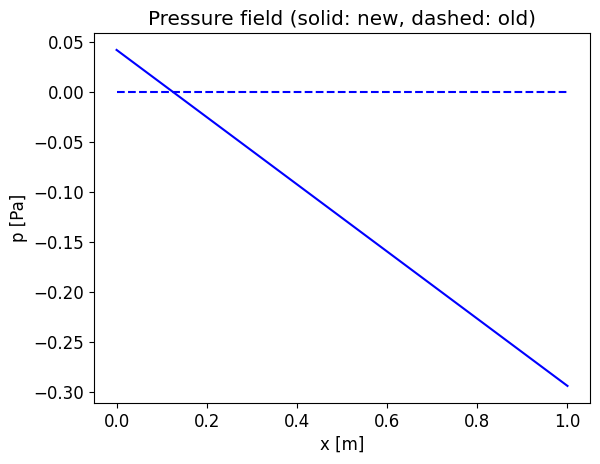

Is pressure gradient balancing source term?
pGrad: -3.35863e-01, b: -5.00000e-02


In [13]:
##########
# STEP 6 #
##########

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
if (not pCorrected):

    #Keep old pressure to see convergence in plot:
    #deepcopy used to avoid making reference.
    p_old = cp.deepcopy(p)

    #Under-relaxation factor needed here:
    alphapp = 0.3

    #Correct (explicitly underrelaxed) pressure:
    p = p + alphapp*pp
   
    #Calculate center pressure gradient, for reporting and extrapolation:
    pGrad = (p[2]-p[1])/dx_PE[1]

    #Constant gradient extrapolation,
    #required to get correct Suu in u-mom. equation!
    p[0] = p[1] - pGrad*dx_WP[1]
    p[3] = p[2] + pGrad*dx_PE[2]

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
pCorrected = True

####################################################
# The rest is just for plotting

# Plot pressure field
plt.figure('Pressure field')
plt.plot(nX, p, 'b')
plt.plot(nX, p_old,'b--')
# Plot settings
plt.xlabel('x [m]')
plt.ylabel('p [Pa]')
plt.title('Pressure field (solid: new, dashed: old)')
plt.show()

print("Is pressure gradient balancing source term?")
print("pGrad: % .5e, b: % .5e" % (pGrad, b))

Stop a while and use your physical knowledge for a sanity check. Is the solution behaving as it should?

In the code below:

1. Correct the internal velocity field according to the derivation. Make sure that you can verify this!
2. Correct the velocity boundary conditions as they should be, according to the case that is studied.

**NOTE THAT THE FOLLOWING CODE SHOULD ONLY BE EXECUTED ONCE PER SIMPLE LOOP!** (why?)

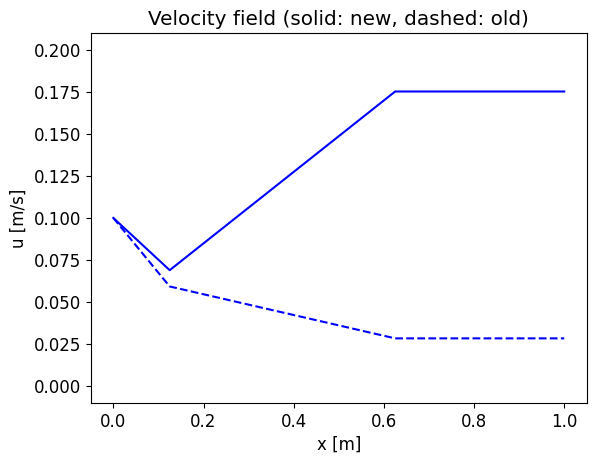

In [14]:
##########
# STEP 7 #
##########

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
if (not uCorrected):

    #Keep old velocity to see convergence in plot:
    #deepcopy used to avoid making reference.
    u_old = cp.deepcopy(u)

    #Correct velocities:
    pp_e = np.array([nan, \
                     (1-f_e[1])*pp[1] + f_e[1]*pp[2], \
                     pp[3], \
                     nan])
    pp_w = np.array([nan, \
                     pp[0], \
                     f_w[2]*pp[1] + (1-f_w[2])*pp[2], \
                     nan])
    #Note in the following that the gradient is actually
    #multiplied by dx_we/dx_we = 1, as in Suu (but here between face values)
    u[1] = u[1] + (pp_w[1] - pp_e[1])/aPu[1]
    u[2] = u[2] + (pp_w[2] - pp_e[2])/aPu[2]
    #Hom. Neumann:
    u[3] = u[2]

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
uCorrected = True

####################################################
# The rest is just for plotting

# Plot velocity field
plt.figure('Velocity field')
plt.plot(nX, u, 'b')
plt.plot(nX, u_old,'b--')
# Plot settings
plt.xlabel('x [m]')
plt.ylabel('u [m/s]')
plt.title('Velocity field (solid: new, dashed: old)')
plt.ylim([u[0]-uDiffMax*1.1, u[0]+uDiffMax*1.1])
plt.show()

In the code below:

1. Correct the face fluxes according to the derivation. Make sure that you can verify this!
2. Correct the boundary conditions as they should be, according to the case that is studied.
3. Make sure that global continuity is fulfilled.

**NOTE THAT THE FOLLOWING CODE SHOULD ONLY BE EXECUTED ONCE PER SIMPLE LOOP!** (why?)

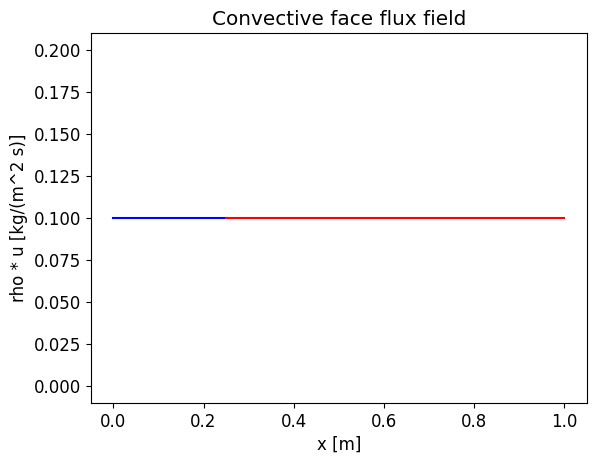

Blue line: Fw[1]:  1.00000e-01, Fw[2]:  1.00000e-01
Red line:  Fe[1]:  1.00000e-01, Fe[2]:  1.00000e-01


In [15]:
##########
# STEP 8 #
##########

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
if (not Fcorrected):

    #Correct face fluxes:
    Fw[2] = Fw[2] + rho*dw[2]*(pp[1]-pp[2])
    Fe[1] = Fe[1] + rho*de[1]*(pp[1]-pp[2])
    #BOUNDARY VALUES SHOULD NOT BE CHANGED!

#Make sure that corrections are done only once per SIMPLE loop (even if clicking again):
Fcorrected  = True

####################################################
# The rest is just for plotting and showing numbers

# Plot velocity field
plt.figure('Convective face flux field')
plt.plot([pX[0],pX[1]], [Fw[1],Fw[2]], 'b')
plt.plot([pX[1],pX[2]], [Fe[1],Fe[2]], 'r')
# Plot settings
plt.xlabel('x [m]')
plt.ylabel('rho * u [kg/(m^2 s)]')
plt.title('Convective face flux field')
plt.ylim([rho*(u[0]-uDiffMax*1.1), rho*(u[0]+uDiffMax*1.1)])
plt.show()

print("Blue line: Fw[1]: % .5e, Fw[2]: % .5e" % (Fw[1], Fw[2]))
print("Red line:  Fe[1]: % .5e, Fe[2]: % .5e" % (Fe[1], Fe[2]))

Have a look at the results at the end of the SIMPLE loop, including results from previous iterations.

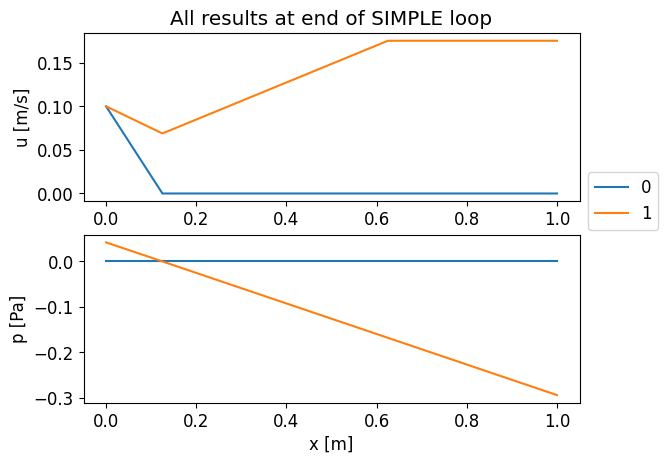

In [16]:
simpleAx1.set_title('All results at end of SIMPLE loop')
simpleAx1.plot(nX, u, label=simpleIter)
pt = simpleAx2.plot(nX, p)
lineColor = pt[0].get_color()
simpleAx1.legend(loc='center left', bbox_to_anchor=(1, 0))
yminAx1, ymaxAx1 = simpleAx1.get_ylim()
yminAx2, ymaxAx2 = simpleAx2.get_ylim()
simpleFig

Have a look at only the current result.

(-0.3106731571384948, 0.0587760027018774)

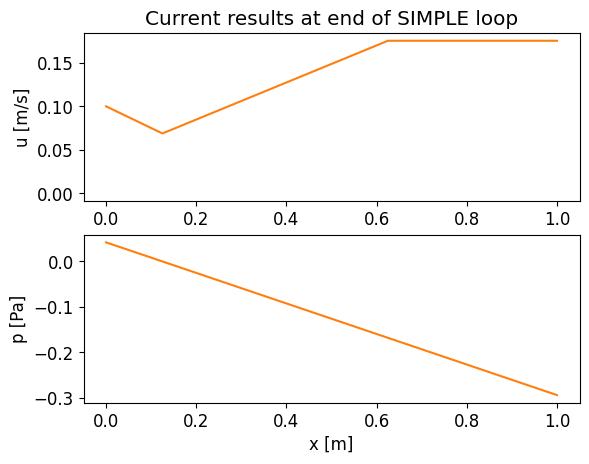

In [17]:
simpleFig2, (simple2Ax1, simple2Ax2) = plt.subplots(2,1)
simple2Ax1.plot(nX, u, color=lineColor, label=0)
simple2Ax1.set_ylabel('u [m/s]')
simple2Ax1.set_title('Current results at end of SIMPLE loop')
simple2Ax1.set_ylim([yminAx1, ymaxAx1])
simple2Ax2.plot(nX, p, color=lineColor, label=0)
simple2Ax2.set_xlabel('x [m]')
simple2Ax2.set_ylabel('p [Pa]')
simple2Ax2.set_ylim([yminAx2, ymaxAx2])

In [18]:
#Pressure gradient (at internal face) should balance b = -0.05
print("Pressure gradient (at internal face): % .5e" % ((p[2]-p[1])/dx_PE[1]))

Pressure gradient (at internal face): -3.35863e-01


**Repeat steps 1-8 to converge** both the momentum and continuity equations at the same time.

[Click here to go to the start of the SIMPLE loop](#STEP_1), mark the STEP 1 cell and click on Cell/Run All Below

You may need to do that 15 times to fully converge, so it is more convenient to add a loop for that. A loop can however not be added over several cells in a Jupyter notebook.

**When you are done**, go back and try to do some modifications:
* Change the position of the center face.
* Try different combinations of underrelaxation factors to see if you can make the solution converge monotonically instead of overshooting.
* Try different combinations of maximum number of Gauss-Seidel iterations for each equation.
* Change the velocity at the west boundary.
* Change the momentum equation source term.
* Change the location of zero pressure.
* Try the central scheme for convection.
* Check where boundary values have to be corrected for the solution procedure (and not only for visualization).
* Etc. ... Use your imagination!